# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Описание данных:
    
    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    Repaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя
Целевой признак - Price — цена (евро)

Цель: найти ту модель машинного обучения, которая будет предсказывать стоимость автомобилей наиболее верно и максимально быстро. 

Задачи: 

    обучить несколько моделей, одна из которых - LGBM
    вычислить метрику качества RMSE (она должна быть меньше 2500)
    вывести время работы моделей
    проанализировать полученные данные

План работы: 

    загрузка и предобработка данных
    подготовка данных к обучению
    обучение моделей
    анализ полученных показателей
    выбор лучшей модели

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

from phik import resources, report
from phik.report import plot_correlation_matrix
import matplotlib.pyplot as plt

In [2]:
df_f = pd.read_csv('autos.csv')
df_f.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Предпросмотр данных проведен: проблем не обнаружено

Сохраним изначальную длину датасета, чтобы потом проверить, не слишком ли большое количество данных исчезло после предобработки

In [4]:
len_1 = len(df_f)

Переименуем столбцы для удобного к ним обращения:

In [5]:
df_f.columns = df_f.columns.str.lower()
df_f.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [6]:
df_f = df_f.rename(columns={'datecrawled': 'date_crawled', 
                        'vehicletype': 'vehicle_type', 
                        'registrationyear': 'registration_year', 
                        'registrationmonth': 'registration_month', 
                        'fueltype': 'fuel_type', 
                        'notrepaired': 'not_repaired', 
                        'datecreated': 'date_created',
                        'numberofpictures': 'number_of_pictures',
                        'postalcode': 'postal_code',
                        'lastseen': 'last_seen'})
df_f.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Избавимся от тех признаков, которые точно не будут влиять на предсказание:

In [7]:
df = df_f.drop(['number_of_pictures', 'postal_code', 'date_created', 
              'last_seen', 'registration_month', 'date_crawled'], axis=1)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Проверим датасет на дубликаты:

In [8]:
df.isna().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

Выведем уникальные значения в каждом из столбцов с пропусками:

In [11]:
for column in df.select_dtypes(exclude='number'):
    print (column, ': ',   df.select_dtypes(exclude='number')[column].unique())
    print(' ')

vehicle_type :  [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
 
gearbox :  ['manual' 'auto' nan]
 
model :  ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 's

Заменим пропущенные значения:

In [12]:
df['vehicle_type'] = df['vehicle_type'].fillna('other')
columns_to_fill = ['model', 'fuel_type', 'repaired', 'gearbox']
df[columns_to_fill] = df[columns_to_fill].fillna('unknown')

df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Заменим для большей репрезнтативности данных названия топлива: petrol и gasoline - это синонимы

In [13]:
df['fuel_type'] = df['fuel_type'].replace('gasoline', 'petrol')
df['fuel_type'].unique()

array(['petrol', 'unknown', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

Проведем проверку на неявные дубликаты:

<br/>
<div class="alert alert-info">
сейчас будет оч странный код, но зато он выполняет свою функцию.... ну и от неявный дубликатов избавляет...
</div>

In [14]:
models = ['golf', np.nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max', '3_reihe',
 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse', 'scirocco', '5er',
 'meriva', 'arosa', 'c4', 'civic', 'transporter', 'punto', 'e_klasse', 'clio',
 'kadett', 'kangoo', 'corsa', 'one', 'fortwo', '1er', 'b_klasse', 'signum',
 'astra', 'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156',
 'escort', 'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
 'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147', '100', 'z_reihe',
 'sportage', 'sorento', 'v40', 'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3',
 'almera', 'megane', 'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba', 'colt',
 'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
 '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti', 'octavia', 'mii',
 'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1', 'rio', 'touareg',
 'logan', 'spider', 'cuore', 's_max', 'a2', 'galaxy', 'c3', 'viano', 's_klasse',
 '1_reihe', 'avensis', 'roomster', 'sl', 'kaefer', 'santa', 'cooper', 'leon',
 '4_reihe', 'a5', '500', 'laguna', 'ptcruiser', 'clk', 'primera', 'x_reihe',
 'exeo', '159', 'transit', 'juke', 'qashqai', 'carisma', 'accord', 'corolla',
 'lanos', 'phaeton', 'verso', 'swift', 'rav', 'picanto', 'boxster', 'kalos',
 'superb', 'stilo', 'alhambra', 'mx_reihe', 'roadster', 'ypsilon', 'cayenne',
 'galant', 'justy', '90', 'sirion', 'crossfire', 'agila', 'duster', 'cr_reihe',
 'v50', 'c_reihe', 'v_klasse', 'm_klasse', 'yaris', 'c5', 'aygo', 'cc', 'carnival',
 'fusion', '911', 'bora', 'forfour', 'm_reihe', 'cl', 'tigra', '300c', 'spark',
 'v70', 'kuga', 'x_type', 'ducato', 's_type', 'x_trail', 'toledo', 'altea',
 'voyager', 'calibra', 'bravo', 'antara', 'tucson', 'citigo', 'jimny', 'wrangler',
 'lybra', 'q7', 'lancer', 'captiva', 'c2', 'discovery', 'freelander', 'sandero',
 'note', '900', 'cherokee', 'clubman', 'samara', 'defender', '601', 'cx_reihe',
 'legacy', 'pajero', 'auris', 'niva', 's60', 'nubira', 'vivaro', 'g_klasse',
 'lodgy', '850', 'range_rover', 'q3', 'serie_2', 'glk', 'charade', 'croma',
 'outlander', 'doblo', 'musa', 'move', '9000', 'v60', '145', 'aveo', '200', 'b_max',
 'range_rover_sport', 'terios', 'rangerover', 'q5', 'range_rover_evoque',
 'materia', 'delta', 'gl', 'kalina', 'amarok', 'elefantino', 'i3', 'kappa',
 'serie_3', 'serie_1']

In [15]:
def normalize_model_name(name):
    if pd.isna(name):
        return name
    return name.lower().replace(' ', '').replace('_', '').replace('-', '')

In [16]:
norm_models = [normalize_model_name(model) for model in models]

In [17]:
model_counts = pd.Series(norm_models).value_counts()
dupl_model = model_counts[model_counts > 1]

In [18]:
print(dupl_model)

rangerover    2
Name: count, dtype: int64


In [19]:
df['model'] = df['model'].replace('rangerover', 'range_rover')

Проверим уникальные значения в столбце с годом регистрации автомобиля:

In [20]:
df['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Сначала отсортируем данные по реальности и посмотрим их распределение:

In [21]:
df = df[(df['registration_year'] >= 1910) & (df['registration_year'] <= 2016)]
df['registration_year'].sort_values().unique()

array([1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016])

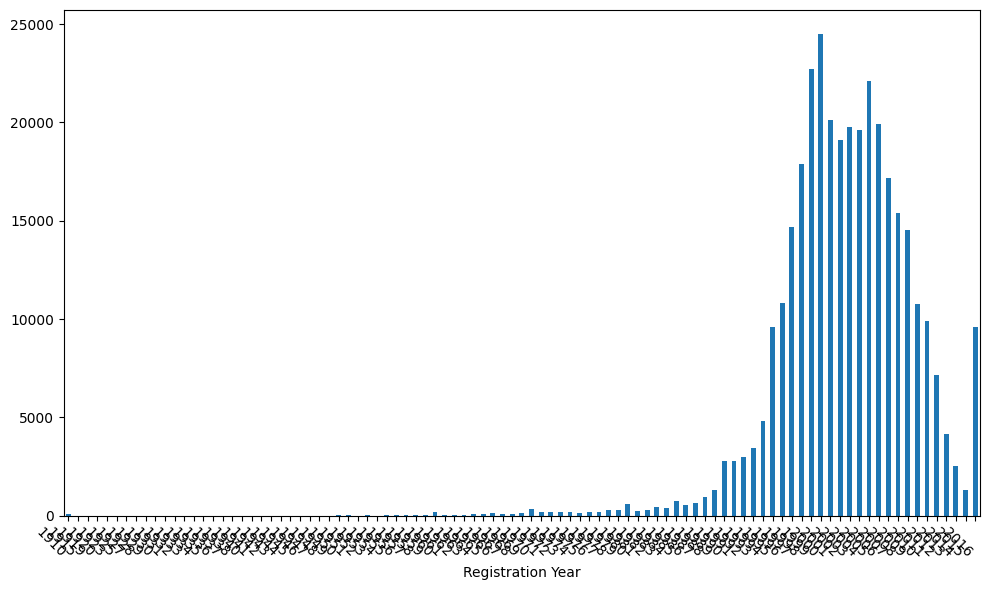

In [22]:
value_counts = df['registration_year'].value_counts().sort_index()
ax = value_counts.plot(kind='bar', figsize=(10, 6))

ax.set_xlabel('Registration Year')
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='right')

plt.tight_layout()
plt.show()

Из гистограммы мы видим, что плотность распределения значений годов регистрации до какого-то, пока не видимого года, мала. Снова отсортируем данные и построим гистограмму:

In [23]:
df = df[(df['registration_year'] >= 1950) & (df['registration_year'] <= 2016)]
df['registration_year'].sort_values().unique()

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016])

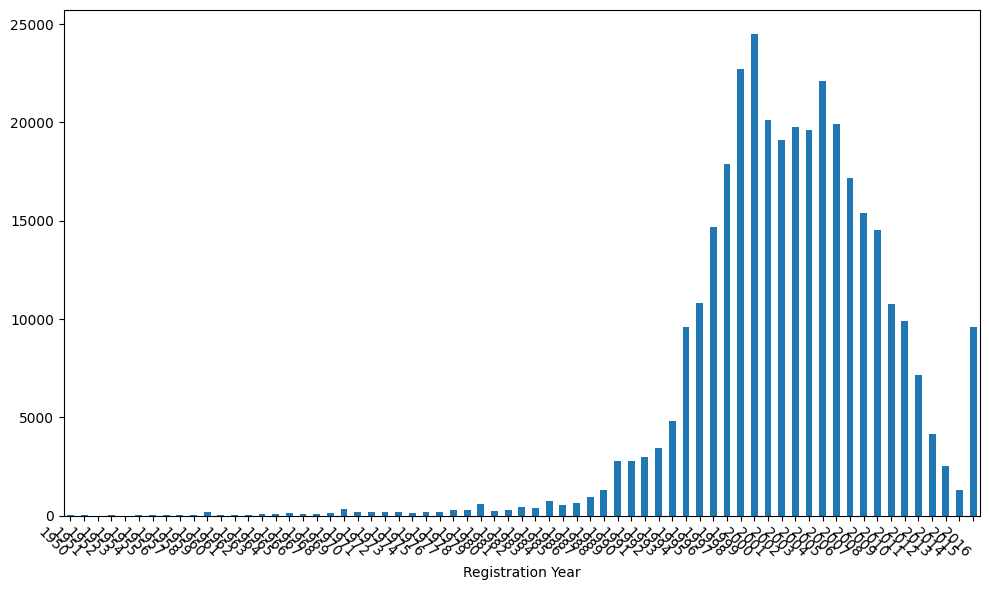

In [24]:
value_counts = df['registration_year'].value_counts().sort_index()
ax = value_counts.plot(kind='bar', figsize=(10, 6))

ax.set_xlabel('Registration Year')
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='right')

plt.tight_layout()
plt.show()

Из гистограммы видно, что плотность распределения годов регистрации автомобилей начинает увеличиваться с 1970-х годов. Отсортируруем таблицу по этому признаку в последний раз: 

In [25]:
df = df[(df['registration_year'] >= 1970) & (df['registration_year'] <= 2016)]
df['registration_year'].sort_values().unique()

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016])

Выведем описательные статистики для столбца с мощностью автомобиля:

In [26]:
stats = df['power'].describe()

print("Описательные статистики для столбца 'power':")
print(stats)

Описательные статистики для столбца 'power':
count    338501.000000
mean        111.144410
std         185.085461
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


В этом признаке много как статистических, так и определнных по здравому смыслу выбросов. Удалим их, используя правило трех сигм:

In [27]:
mean_power = df['power'].mean()
std_power = df['power'].std()
upper_bound = mean_power + 3 * std_power

print(f"Верхняя граница: {round(upper_bound, 2)}")

Верхняя граница: 666.4


In [28]:
df = df[df['power'] <= 667]

Также похожими на правду сделаем значения с ценой автомобиля:

In [29]:
df['price'].sort_values().unique()

array([    0,     1,     2, ..., 19998, 19999, 20000])

In [30]:
df = df[df['price'] > 50]

Проверим и пробег:

In [31]:
df['kilometer'].describe()

count    326497.000000
mean     128507.581999
std       37119.875385
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

Из описательных статистик можно сделать вывод, что данные удовлетворительные и могут быть использованы при построении моделей.

Проверим датасет после всех удалененных данных на дубликаты и избавимся от них:

In [33]:
df.duplicated().sum()

42947

In [34]:
df = df.drop_duplicates().reset_index(drop=True)

In [35]:
df.duplicated().sum()

0

Посмотрим, какая часть датасета была потеряна на этапе предобработки данных:

In [36]:
len_3 = len(df)
perc = round(1-len_3/len_1, 3)
perc

0.2

Получается, наш датасет стал на 20% меньше! Однако данные теперь могут быть полезными и участвовать в обучении моделей!

## Корреляционный анализ

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer']


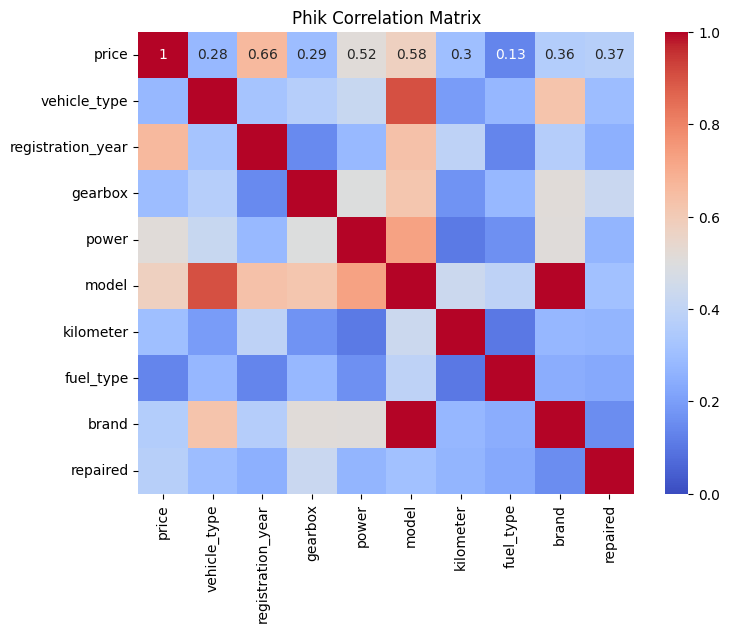

In [37]:
phik_matrix = df.phik_matrix()

plt.figure(figsize=(8, 6))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Phik Correlation Matrix")
plt.show()

Из корреляционной матрицы можно сделать вывод, что признаки "brand" и "model" имеют сильную корреляцию, при этом "brand" меньше коррелирует с целевым признаком, чем "model", поэтому удалим его.

In [38]:
df.drop('brand', axis=1, inplace=True)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,repaired
0,480,other,1993,manual,0,golf,150000,petrol,unknown
1,18300,coupe,2011,manual,190,unknown,125000,petrol,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,no
4,3600,small,2008,manual,69,fabia,90000,petrol,no


## Обучение моделей

Сперва подготовим данные для каждой из моделей и закодируем их:

### Прямое кодирование

In [39]:
data = pd.get_dummies(df, drop_first=True)
data

,price,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unknown,repaired_unknown,repaired_yes
0,480,1993,0,150000,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,True,False
1,18300,2011,190,125000,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
2,9800,2004,163,125000,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,True,False
3,1500,2001,75,150000,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
4,3600,2008,69,90000,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283545,3200,2004,225,150000,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True
283546,2200,2005,0,20000,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,True,False
283547,1199,2000,101,125000,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
283548,9200,1996,102,150000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [40]:
X = data.drop('price', axis=1)
y = data['price']

In [41]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Порядковое кодирование

In [43]:
target = df['price']
features = df.drop('price', axis=1)

In [44]:
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(features)

In [45]:
X_train_1, X_temp_1, y_train_1, y_temp_1 = train_test_split(X_encoded, y, test_size=0.3, random_state=42)
X_val_1, X_test_1, y_val_1, y_test_1 = train_test_split(X_temp_1, y_temp_1, test_size=0.5, random_state=42)

In [46]:
scaler = StandardScaler()
X_train_scaled_1 = scaler.fit_transform(X_train_1)
X_val_scaled_1 = scaler.transform(X_val_1)
X_test_scaled_1 = scaler.transform(X_test_1)

Для каждой модели, подбирая гиперпараметры, будем использовать две выборки: тренировочную и валидационную. После выбора лучшей модели воспользуемся, наконец, тестовой.

### Linear Regression

У линейной модели нет гиперпараметров, поэтому обучим ее просто так, предварительно их стандартизировав, и выведем необходимую метрику:

In [47]:
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

lr_y_pred_val = model_lr.predict(X_val_scaled)

lr_rmse = np.sqrt(mean_squared_error(y_val, lr_y_pred_val))
print(f'RMSE on validation set: {lr_rmse}')

RMSE on validation set: 2724.973629722926


### LGBM

Обучим модель и выведем RMSE:

In [48]:
model_lgbm = lgb.LGBMRegressor(random_state=12345)
model_lgbm.fit(X_train_scaled_1, y_train_1)

lgbm_y_pred_val = model_lgbm.predict(X_val_scaled_1)
lgbm_rmse = np.sqrt(mean_squared_error(y_val_1, lgbm_y_pred_val))
print(f'RMSE on validation set: {lgbm_rmse}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 591
[LightGBM] [Info] Number of data points in the train set: 198485, number of used features: 8
[LightGBM] [Info] Start training from score 4710.035106
RMSE on validation set: 1792.382905424475


Определим наилучшие гиперпараметры для модели на валидационной выборке:

In [49]:
param_grid = {
    'n_estimators': [100, 500],
    'num_leaves': [n for n in range(120, 260, 20)]
}

best_params = None
best_rmse = float('inf')

In [50]:
for params in ParameterGrid(param_grid):
    model = lgb.LGBMRegressor(**params, random_state=12345)
    model.fit(X_train_scaled_1, y_train_1)
    y_pred_val = model.predict(X_val_scaled_1)
    rmse = np.sqrt(mean_squared_error(y_val_1, y_pred_val))
    print(f'Params: {params}, RMSE: {rmse}')
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print(f'Best params: {best_params}')
print(f'Best score (RMSE): {best_rmse}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 591
[LightGBM] [Info] Number of data points in the train set: 198485, number of used features: 8
[LightGBM] [Info] Start training from score 4710.035106
Params: {'n_estimators': 100, 'num_leaves': 120}, RMSE: 1671.785169746243
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 591
[LightGBM] [Info] Number of data points in the train set: 198485, number of used features: 8
[LightGBM] [Info] Start training from score 4710.035106
Params: {'n_estimators': 100, 'num_leaves': 140}, RMSE: 1660.8554503114904
[LightGBM] [Info] Auto-choosing row

Получается, что для этой модели лучшими гиперпараметрами являются n_estimators = 500 и num_leaves = 180. Показатель RMSE для этих параметров составляет 1606.74

### Decision Tree

Определим гиперпараметры, посчитаем RMSE на валидационной выборке для каждых из них:

In [54]:
for depth in range(3, 20, 3):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(X_train_scaled_1, y_train_1)
    dsr_pred_val = model.predict(X_val_scaled_1)
    rmse = mean_squared_error(y_val_1, dsr_pred_val)**0.5
    print('Глубина:', depth)
    print('RMSE для решающего дерева на валидационной выборке:', rmse)
    print('')
print()

Глубина: 3
RMSE для решающего дерева на валидационной выборке: 2958.631017727267

Глубина: 6
RMSE для решающего дерева на валидационной выборке: 2321.9993673701674

Глубина: 9
RMSE для решающего дерева на валидационной выборке: 2089.3315166821317

Глубина: 12
RMSE для решающего дерева на валидационной выборке: 1981.1903865313257

Глубина: 15
RMSE для решающего дерева на валидационной выборке: 1989.2145106443022

Глубина: 18
RMSE для решающего дерева на валидационной выборке: 2039.4353437485397




Сделаем аналогично на тестовой выборке:

In [55]:
for depth in range(3, 20, 3):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(X_train_scaled_1, y_train_1)
    dsr_pred_val = model.predict(X_test_scaled_1)
    rmse = mean_squared_error(y_test_1, dsr_pred_val)**0.5
    print('Глубина:', depth)
    print('RMSE для решающего дерева на тестовой выборке:', rmse)
    print('')
print()

Глубина: 3
RMSE для решающего дерева на тестовой выборке: 2964.806006428352

Глубина: 6
RMSE для решающего дерева на тестовой выборке: 2335.9714613343185

Глубина: 9
RMSE для решающего дерева на тестовой выборке: 2141.8734743837013

Глубина: 12
RMSE для решающего дерева на тестовой выборке: 2049.945551810997

Глубина: 15
RMSE для решающего дерева на тестовой выборке: 2055.1487536056

Глубина: 18
RMSE для решающего дерева на тестовой выборке: 2102.751979252722




Сравнивая RMSE для одних и тех же гиперпараметров на тренировочной и валидационной выборках, можно сделать вывод о том, что такая модель, как дерево решений, склонна к переобучению.

## Анализ моделей

### Linear Regression

In [56]:
%%time
# время обучения модели линейной регрессии
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

CPU times: user 23.6 s, sys: 2.7 s, total: 26.3 s
Wall time: 5.34 s


LinearRegression()

In [57]:
%%time
# время предсказания на тренировочной выборке
lr_predd_train = model_lr.predict(X_train_scaled)

CPU times: user 211 ms, sys: 3.39 ms, total: 214 ms
Wall time: 58.7 ms


### LGBM

In [58]:
%%time
# время обучения LGBM
model_lgbm = lgb.LGBMRegressor(random_state=12345,
                          n_estimators=500,
                          num_leaves=180)
model_lgbm.fit(X_train_scaled_1, y_train_1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 591
[LightGBM] [Info] Number of data points in the train set: 198485, number of used features: 8
[LightGBM] [Info] Start training from score 4710.035106
CPU times: user 33.8 s, sys: 6.09 s, total: 39.9 s
Wall time: 8.89 s


LGBMRegressor(n_estimators=500, num_leaves=180, random_state=12345)

In [59]:
%%time
# время предсказания на тренировочной выборке LGBM
lgbm_predd_train = model_lgbm.predict(X_train_scaled_1)

CPU times: user 9.37 s, sys: 58.4 ms, total: 9.43 s
Wall time: 1.73 s


### Decision Tree

In [60]:
%%time
# время обучения модели решающего дерева
model_dtr = DecisionTreeRegressor(random_state=12345, max_depth=9)
model_dtr.fit(X_train_scaled_1, y_train_1)

CPU times: user 406 ms, sys: 213 ms, total: 619 ms
Wall time: 201 ms


DecisionTreeRegressor(max_depth=9, random_state=12345)

In [61]:
%%time
# время предсказания на тренировочной выборке модели решающего дерева
predictions_train = model_dtr.predict(X_train_scaled_1)

CPU times: user 11.2 ms, sys: 1.3 ms, total: 12.5 ms
Wall time: 11.7 ms


In [67]:
tabledata = [["Linear Regression: обучение", "26.3 s", "5.34 s", 'none'],
             ["Linear Regression: предсказание", "214 ms", "58.7 ms", '2724.97'],
             ["LightGBM: обучение", "39.9 s", "8.89 s", 'none'],
             ["LightGBM: предсказание", "9.43 s", "1.73 s", '1606.74'],
             ["Decision Tree: обучение", "619 ms", "201 s", 'none'],
             ["Decision Tree: предсказание", "12.5 ms", "11.7 ms", '1981.19']]
df = pd.DataFrame(tabledata, columns=["model", "CPU-times", "Wall time", 'RMSE'])
df = df.set_index('model')
df.index.names = [None]
df

,CPU-times,Wall time,RMSE
Linear Regression: обучение,26.3 s,5.34 s,none
Linear Regression: предсказание,214 ms,58.7 ms,2724.97
LightGBM: обучение,39.9 s,8.89 s,none
LightGBM: предсказание,9.43 s,1.73 s,1606.74
Decision Tree: обучение,619 ms,201 s,none
Decision Tree: предсказание,12.5 ms,11.7 ms,1981.19


Таким образом, наиболее качественно предсказывает LGBM, но при этом она дольше всех обучается и предсказывает. На мой взгляд, наиболее подходящей для заказчика моделью явялется LGBM, потому что тогда предлагаемый им продукт будет качественным, хоть и будет выполнять основную функцию дольше, чем мог бы, если бы делал это некачественно.

### Проверка лучшей модели

In [81]:
params = {
    'n_estimators': 500,
    'num_leaves': 180
}

In [82]:
best_model = lgb.LGBMRegressor(**params)
best_model.fit(X_train_scaled_1, y_train_1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 591
[LightGBM] [Info] Number of data points in the train set: 198485, number of used features: 8
[LightGBM] [Info] Start training from score 4710.035106


LGBMRegressor(n_estimators=500, num_leaves=180)

In [83]:
y_pred = best_model.predict(X_test_scaled_1)

In [85]:
rmse = np.sqrt(mean_squared_error(y_test_1, y_pred))
print(f'RMSE on test set: {rmse}')

RMSE on test set: 1635.05162303166


Таким образом, лучшая модель показала RMSE на тестовой выборке ниже, чем на валидационной, что говорит о том, что модель не переобучена и выбор в ее пользу сделан верно!

## Общий вывод

    1. При предобработке данных мы избавились от практически 20% от них в силу их нерепрезентативности;
    2. При обучении моделей использовались различные типы кодирования категориальных столбцов и различные гиперпарметры;
    3. Лучшей моделью выступила LGBM с количеством деревьев 500 и количеством листьев 120.
Заказчику я бы предложила также оценить количество владельцев, их пол (как бы по-сексистки это ни звучало), а также страну-производителя автомобиля, так как машины со сборкой в разных странах на рынке стоят по-разному.